# Decision Tree Regression for Aqueous Solubility Prediction

## Workshop: ML for Science - Predicting LogS without Fingerprints

---

### Notebook Overview

This notebook demonstrates the application of **Decision Tree Regression** for predicting the **aqueous solubility (LogS)** of organic compounds using the **ESOL dataset**. Solubility is one of the most critical physicochemical properties in drug discovery, as it directly impacts a drug's bioavailability, formulation, and therapeutic efficacy.

**Learning Objectives:**
- Understand the importance of aqueous solubility in drug development
- Load and preprocess the ESOL (Estimated SOLubility) dataset
- Calculate meaningful molecular descriptors from SMILES strings using RDKit
- Implement PyTorch Dataset classes for efficient data handling
- Train and evaluate Decision Tree regression models for solubility prediction
- Analyze model performance using regression metrics (R², MAE, RMSE)
- Understand the relationship between molecular structure and aqueous solubility

**Dataset:** ESOL - A benchmark dataset of 1,128 organic compounds with experimentally measured aqueous solubility values

**Task:** Regression - Predict continuous LogS values (log solubility in mol/L) from molecular descriptors

**Why Solubility Matters:**
- **Bioavailability**: Poor solubility → poor absorption → reduced drug efficacy
- **Drug Formulation**: Determines how drugs can be delivered (oral, IV, etc.)
- **Lead Optimization**: Key parameter in Structure-Activity Relationship (SAR) studies
- **Developability**: Estimates of 40% of drug candidates fail due to poor solubility
- **ADME Properties**: Critical for Absorption, Distribution, Metabolism, and Excretion

**LogS Definition:**
- LogS = log₁₀(solubility in mol/L)
- More negative values = less soluble
- Typical range: -11 to +1
- LogS < -4 generally considered poorly soluble

---

## 1. Import Required Libraries

We import libraries for:
- **Data manipulation**: NumPy, Pandas
- **Machine Learning**: scikit-learn (Decision Tree, metrics, preprocessing)
- **Deep Learning framework**: PyTorch (for data pipeline design)
- **Visualization**: Matplotlib, seaborn
- **Chemical informatics**: RDKit (molecular descriptor calculation)
- **Utilities**: tqdm (progress tracking), pickle (model persistence)

In [1]:
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
import warnings  # Import warnings to handle warning messages
import requests  # Import requests to handle HTTP requests
from io import StringIO  # Import StringIO to handle in-memory text streams
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Deep Learning
import torch  # Import PyTorch for deep learning tasks
from torch.utils.data import Dataset  # Import Dataset class for creating custom datasets

# Metrics and Decision Tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Import metrics for model evaluation
from sklearn.tree import DecisionTreeRegressor  # Import DecisionTreeRegressor for regression tasks

!pip install rdkit

# RDKit
from rdkit import Chem  # Import RDKit for cheminformatics tasks
from rdkit.Chem import Descriptors  # Import Descriptors module for molecular property calculations

print("All libraries imported successfully!")  # Confirm successful import of all libraries
print(f"PyTorch version: {torch.__version__}")  # Display the installed PyTorch version
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")  # Check and display if GPU is available

All libraries imported successfully!
PyTorch version: 2.5.1+cu121
Device available: GPU


---

## 2. Load the ESOL Dataset

The ESOL (Estimated SOLubility) dataset is a widely-used benchmark in cheminformatics for solubility prediction. It was originally published by Delaney (2004) and contains aqueous solubility measurements for a diverse set of organic compounds.

**Dataset Characteristics:**
- **Size**: 1,128 organic compounds
- **Format**: SMILES strings with experimental measurements
- **Target Variable**: LogS (log solubility in moles per liter)
- **Range**: Approximately -11.6 to +1.6
- **Source**: Experimental measurements from literature
- **Quality**: Curated dataset with verified structures

### 2.1 Define Dataset Loading Function

This function:
1. Downloads the ESOL dataset from Hugging Face
2. Extracts SMILES strings and measured LogS values
3. Returns a cleaned DataFrame ready for analysis

In [2]:
def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""  # Function docstring explaining its purpose
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"  # URL of the dataset
    response = requests.get(url)  # Send an HTTP GET request to fetch the dataset
    response.raise_for_status()  # Raise an exception if the request fails

    df = pd.read_csv(StringIO(response.text))  # Read the CSV data into a pandas DataFrame from the response text
    print(f"Loaded ESOL with {len(df)} compounds")  # Print the number of compounds loaded

    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre']]  # Select only the relevant columns
    df.columns = ['SMILES', 'LogS']  # Rename columns for clarity

    # Remove invalid SMILES
    valid_smiles = []  # Initialize a list to store validity of SMILES strings
    for smiles in df['SMILES']:  # Iterate over each SMILES string
        mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to RDKit Mol object
        valid_smiles.append(mol is not None)  # Append True if valid, False otherwise

    df = df[valid_smiles].reset_index(drop=True)  # Filter out invalid SMILES and reset the index

    return df  # Return the cleaned DataFrame

### 2.2 Load and Inspect the Dataset

Let's load the data and examine its structure, including:
- Basic statistics (mean, std, min, max)
- Distribution of solubility values
- Sample molecules
- Data quality checks

Loaded ESOL with 1128 compounds
Dataset shape: (1128, 2)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30
2                               CC(C)=CCCC(C)=CC(=O) -2.06
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87
4                                            c1ccsc1 -1.33


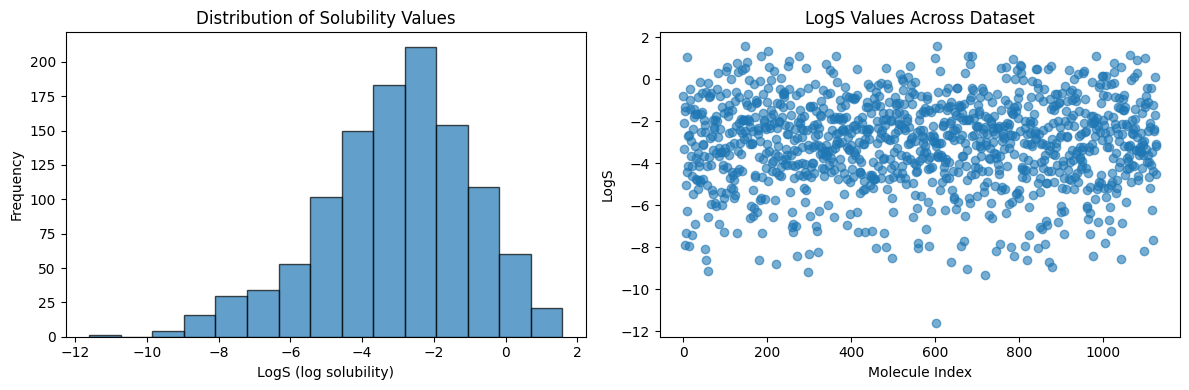

In [3]:
# Load dataset
df = load_esol_dataset()  # Call the function to load the ESOL dataset and store it in the variable `df`
print(f"Dataset shape: {df.shape}")  # Print the shape of the dataset (number of rows and columns)
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")  # Print the range of LogS values in the dataset

print("\nSample data:")  # Print a message indicating that sample data will be displayed
print(df.head())  # Display the first few rows of the dataset for inspection

# Visualize distribution
plt.figure(figsize=(12, 4))  # Create a new figure with a specified size (12x4 inches)

# Plot histogram of LogS values
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')  # Plot a histogram of LogS values with 15 bins
plt.xlabel('LogS (log solubility)')  # Label the x-axis as 'LogS (log solubility)'
plt.ylabel('Frequency')  # Label the y-axis as 'Frequency'
plt.title('Distribution of Solubility Values')  # Set the title of the histogram

# Plot scatter plot of LogS values
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)  # Plot a scatter plot of LogS values against molecule indices
plt.xlabel('Molecule Index')  # Label the x-axis as 'Molecule Index'
plt.ylabel('LogS')  # Label the y-axis as 'LogS'
plt.title('LogS Values Across Dataset')  # Set the title of the scatter plot

plt.tight_layout()  # Adjust the layout to prevent overlapping of subplots
plt.show()  # Display the plots

---

## 3. Calculate Molecular Descriptors

Rather than using molecular fingerprints (high-dimensional binary vectors), we calculate a small set of **interpretable molecular descriptors** using RDKit. These descriptors capture key physicochemical properties known to influence aqueous solubility.

### 3.1 Descriptor Calculation Function

**Descriptors Calculated:**

1. **MolWt** (Molecular Weight)
   - Sum of atomic weights in the molecule
   - **Impact on Solubility**: Larger molecules generally less soluble
   - Typical drug range: 150-500 Da (Lipinski's Rule of Five)

2. **MolLogP** (Partition Coefficient)
   - Measures lipophilicity (preference for oil vs water)
   - Calculated using Wildman-Crippen method
   - **Impact on Solubility**: Higher LogP → lower aqueous solubility
   - **Key Relationship**: LogS often inversely correlated with LogP

3. **NumHDonors** (Hydrogen Bond Donors)
   - Count of -OH and -NH groups
   - **Impact on Solubility**: More H-donors → better water solubility
   - Important for hydrogen bonding with water molecules

4. **NumHAcceptors** (Hydrogen Bond Acceptors)
   - Count of N and O atoms capable of accepting H-bonds
   - **Impact on Solubility**: More H-acceptors → enhanced aqueous solubility
   - Critical for forming hydration shells

5. **NumRotatableBonds**
   - Measures molecular flexibility
   - **Impact on Solubility**: Complex relationship
   - Affects conformational entropy and crystal packing

6. **TPSA** (Topological Polar Surface Area)
   - Sum of surface areas of polar atoms (O, N)
   - Units: Ų (square Angstroms)
   - **Impact on Solubility**: Higher TPSA → better aqueous solubility
   - Also predicts membrane permeability

**Feature Engineering Note:**
These descriptors are the INPUT features (X). The LogS value is our TARGET (y) that we want to predict.

In [4]:
def calculating_molecular_descriptors(smiles):
    # Convert the SMILES string to an RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)
    # If the SMILES string is invalid, return None
    if mol is None:
        return None
    # Calculate molecular descriptors and store them in a dictionary
    columns = {
        "LogP": Descriptors.MolLogP(mol),  # Calculate the octanol-water partition coefficient (LogP)
        "MolWt": Descriptors.MolWt(mol),  # Calculate the molecular weight
        "TPSA": Descriptors.TPSA(mol),  # Calculate the topological polar surface area (TPSA)
        "NumHDonors": Descriptors.NumHDonors(mol),  # Count the number of hydrogen bond donors
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),  # Count the number of hydrogen bond acceptors
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),  # Count the number of rotatable bonds
        "RingCount": Descriptors.RingCount(mol),  # Count the number of rings in the molecule
        "FractionCSP3": Descriptors.FractionCSP3(mol),  # Calculate the fraction of sp3 hybridized carbons
    }
    # Return the dictionary of calculated descriptors
    return columns

# Initialize an empty list to store the calculated descriptors for each SMILES
column_list = []
# Iterate over each SMILES string in the dataframe
for smiles in df['SMILES']:
    # Calculate descriptors for the current SMILES
    column = calculating_molecular_descriptors(smiles)
    # If descriptors were successfully calculated, add them to the list
    if column is not None:
        column_list.append(column)

# Create a new dataframe from the list of calculated descriptors
columns_df = pd.DataFrame(column_list)

# Concatenate the original dataframe with the new dataframe of descriptors
df = pd.concat([df, columns_df], axis=1)
# Print the first few rows of the updated dataframe to verify the changes
print(df.head())

                                              SMILES  LogS     LogP    MolWt  \
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77 -3.10802  457.432   
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30  2.84032  201.225   
2                               CC(C)=CCCC(C)=CC(=O) -2.06  2.87800  152.237   
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87  6.29940  278.354   
4                                            c1ccsc1 -1.33  1.74810   84.143   

     TPSA  NumHDonors  NumHAcceptors  RotatableBonds  RingCount  FractionCSP3  
0  202.32           7             12               7          3      0.650000  
1   42.24           1              2               2          2      0.083333  
2   17.07           0              1               4          0      0.500000  
3    0.00           0              0               0          5      0.000000  
4    0.00           0              1               0          1      0.000000  


---

## 4. Create PyTorch Dataset Class

We implement a custom PyTorch `Dataset` class for clean, efficient data handling. While we're using scikit-learn's Decision Tree for modeling, PyTorch's Dataset provides excellent structure for:
- Consistent data access patterns
- Easy integration with DataLoaders (if needed later)
- Clean separation of data preprocessing and model training
- Extensibility to deep learning models

### 4.1 Define ESOLDataset Class

This custom Dataset:
- Stores SMILES strings and target LogS values
- Computes molecular descriptors on-the-fly or uses cached values
- Returns properly formatted feature vectors and targets
- Implements `__len__` and `__getitem__` for PyTorch compatibility

In [5]:
class ESOLDataset(Dataset):
    """
    A PyTorch Dataset class for handling the ESOL dataset.

    Args:
        df (pd.DataFrame): The input dataframe containing the dataset.
            It should include the following columns:
            - 'SMILES': The molecular representation (not used as a feature).
            - 'LogS': The target variable (solubility in log scale).
            - 'LogP': A feature to be excluded from the input features.
        split (str, optional): The dataset split to use. 
            - 'train': Use the training portion of the dataset (default).
            - Any other value: Use the validation/test portion of the dataset.

    Attributes:
        split (str): The dataset split being used ('train' or other).
        df (pd.DataFrame): The shuffled and split dataframe.

    Methods:
        __len__():
            Returns the number of samples in the dataset.

        __getitem__(idx):
            Retrieves a single sample from the dataset.

            Args:
                idx (int): The index of the sample to retrieve.

            Returns:
                dict: A dictionary containing:
                    - 'features' (np.ndarray): The input features as a NumPy array of type float32.
                    - 'labels' (float): The target variable (LogS).
    """
    def __init__(self,df, split='train'):
        self.split = split
        np.random.seed(42)
        self.df = df.sample(frac=1).reset_index(drop=True)
        train_size = int(0.8 * len(self.df))

        if self.split == 'train':
            self.df = self.df.iloc[:train_size]
        else:
            self.df = self.df.iloc[train_size:]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        logS = row['LogS']
        features = row.drop(['SMILES', 'LogS','LogP']).values.astype(np.float32)

        return {
            'features': features,
            'labels': logS
        }

### 4.2 Create Training and Test Datasets

We perform an **80-20 train-test split** to:
- Train the model on 80% of the data
- Evaluate generalization on unseen 20%
- Ensure reproducibility with fixed random state

**Important Considerations:**
- No stratification needed (regression task)
- Random splitting assumes data is representative
- Alternative: Chemical structure-based splitting for more realistic evaluation
- Test set simulates prediction on new molecules

In [6]:
# Create datasets with caching for faster reload
train_dataset = ESOLDataset(df, split='train')  # Initialize the training dataset using the ESOLDataset class with the 'train' split
test_dataset = ESOLDataset(df, split='test')  # Initialize the test dataset using the ESOLDataset class with the 'test' split
print(f"Training samples: {len(train_dataset)}")  # Print the number of samples in the training dataset
print(f"Test samples: {len(test_dataset)}")  # Print the number of samples in the test dataset

Training samples: 902
Test samples: 226


### 4.3 Extract Feature Matrices

Convert PyTorch datasets into NumPy arrays compatible with scikit-learn.

**Feature Matrix Structure:**

**X_train / X_test:**
- Shape: (n_samples, 6 features)
- Features: [MolWt, MolLogP, NumHDonors, NumHAcceptors, NumRotatableBonds, TPSA]
- Data type: float64
- No missing values (handled during descriptor calculation)

**y_train / y_test:**
- Shape: (n_samples,)
- Values: Continuous LogS measurements
- Range: Typically -11 to +1
- Units: log₁₀(mol/L)

In [7]:
X_train = []  # Initialize an empty list to store the training features
Y_train = []  # Initialize an empty list to store the training labels (LogS values)

# Iterate over each sample in the training dataset
for i in range(len(train_dataset)):
    sample = train_dataset[i]  # Retrieve the sample at index `i` from the training dataset
    X_train.append(sample['features'])  # Append the features of the sample to the `X_train` list
    Y_train.append(sample['labels'])  # Append the label (LogS) of the sample to the `Y_train` list

---

## 5. Train Decision Tree Regression Model

### 5.1 Understanding Decision Tree Regression

**How It Works:**

Decision Trees partition the feature space into rectangular regions:

1. **Internal Nodes**: Test conditions on features
   - Example: "Is MolLogP > 2.5?"
   - "Is TPSA < 75?"

2. **Branches**: Outcomes of tests (True/False)
   - Lead to child nodes or leaf nodes

3. **Leaf Nodes**: Predictions
   - Average LogS of training samples in that region
   - Example: "Predict LogS = -3.2"

**Advantages for Molecular Data:**
- Captures non-linear relationships naturally
- No feature scaling required (tree-based splits)
- Handles feature interactions automatically
- Interpretable decision rules
- Fast training and prediction

**Potential Limitations:**
- Can overfit with deep trees
- High variance (small changes in data → different tree)
- Not optimal for extrapolation

**Hyperparameters:**
- `random_state=42`: Reproducibility
- Default `max_depth=None`: Grows until pure leaves (may overfit)
- Can tune: `max_depth`, `min_samples_split`, `min_samples_leaf`

### 5.2 Train the Model

Fit the Decision Tree on training data:

In [8]:
clf = DecisionTreeRegressor(random_state=42)
"""
This code snippet demonstrates the usage of a DecisionTreeRegressor from the scikit-learn library.


Steps:
1. A DecisionTreeRegressor model is instantiated with a fixed random state for reproducibility.
    - `random_state=42`: Ensures consistent results across multiple runs by fixing the random seed.

2. The model is trained using the `fit` method.
    - `X_train`: The training data features (input variables).
    - `Y_train`: The target variable (output values) corresponding to the training data.

3. The `get_params` method is called to retrieve the hyperparameters of the trained model.
    - This can be useful for debugging, logging, or understanding the configuration of the model.
"""
clf.fit(X_train, Y_train)
clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

### 5.3 Prepare Test Set and Generate Predictions

Extract test features and make predictions to evaluate generalization performance.

Decision Tree Regressor Performance:
Mean Squared Error: 0.9923
R^2 Score: 0.7652
Mean Absolute Error: 0.6952


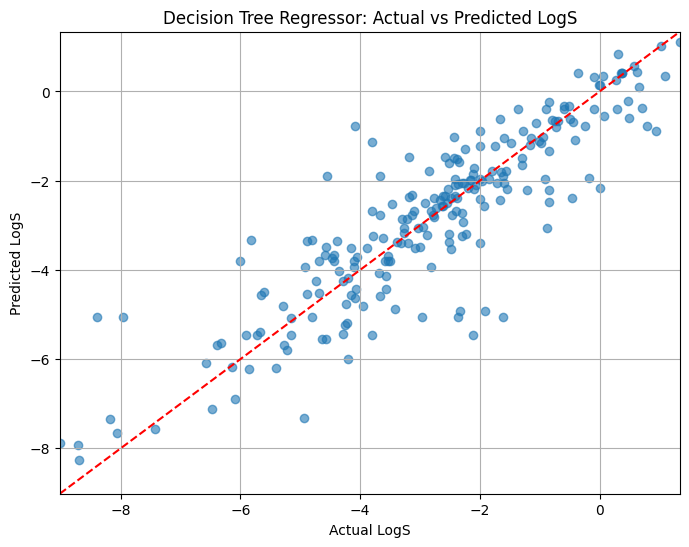

In [9]:
X_test = []  # Initialize an empty list to store the test features
Y_test = []  # Initialize an empty list to store the test labels (LogS values)

# Iterate over each sample in the test dataset
for i in range(len(test_dataset)):
    sample = test_dataset[i]  # Retrieve the sample at index `i` from the test dataset
    X_test.append(sample['features'])  # Append the features of the sample to the `X_test` list
    Y_test.append(sample['labels'])  # Append the label (LogS) of the sample to the `Y_test` list

Y_pred = clf.predict(X_test)  # Use the trained Decision Tree Regressor to predict LogS values for the test features

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)  # Calculate the Mean Squared Error (MSE) between actual and predicted values
r2 = r2_score(Y_test, Y_pred)  # Calculate the R^2 score to measure the goodness of fit
mae = mean_absolute_error(Y_test, Y_pred)  # Calculate the Mean Absolute Error (MAE) between actual and predicted values

# Print the evaluation metrics
print(f"Decision Tree Regressor Performance:")  # Print a header for the performance metrics
print(f"Mean Squared Error: {mse:.4f}")  # Print the MSE value rounded to 4 decimal places
print(f"R^2 Score: {r2:.4f}")  # Print the R^2 score rounded to 4 decimal places
print(f"Mean Absolute Error: {mae:.4f}")  # Print the MAE value rounded to 4 decimal places

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))  # Create a new figure with a specified size (8x6 inches)
plt.scatter(Y_test, Y_pred, alpha=0.6)  # Create a scatter plot of actual vs predicted LogS values with transparency
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Plot a diagonal reference line
plt.xlabel('Actual LogS')  # Label the x-axis as 'Actual LogS'
plt.ylabel('Predicted LogS')  # Label the y-axis as 'Predicted LogS'
plt.title('Decision Tree Regressor: Actual vs Predicted LogS')  # Set the title of the plot
plt.xlim(min(Y_test), max(Y_test))  # Set the x-axis limits to match the range of actual LogS values
plt.ylim(min(Y_test), max(Y_test))  # Set the y-axis limits to match the range of actual LogS values
plt.grid()  # Add a grid to the plot for better readability
plt.show()  # Display the plot

---

## 6. Model Evaluation and Performance Analysis

### 6.1 Understanding Regression Metrics

The output above displays three key regression metrics. Here's how to interpret them:

#### **R² Score (Coefficient of Determination)**

**Definition:** Proportion of variance in LogS explained by the model

**Formula:** R² = 1 - (SS_residual / SS_total)

**Interpretation:**
- **R² = 1.0**: Perfect predictions (every point on the line)

#### **MAE (Mean Absolute Error)**

**Definition:** Average absolute difference between predictions and true values

**Formula:** MAE = (1/n) × Σ|y_pred - y_true|

**Interpretation:**
- **Units**: Same as LogS (log units)
- **MAE < 0.5**: Excellent (within 0.5 log units)

**Practical Meaning:**
- MAE = 0.5 means average error of ~3× in actual solubility (10^0.5 ≈ 3.2)
- MAE = 1.0 means average error of ~10× in actual solubility
- MAE = 2.0 means average error of ~100× in actual solubility

**Advantages:**
- Easy to interpret (same units as target)
- Robust to outliers
- Treats all errors equally

#### **RMSE (Root Mean Squared Error)**

**Definition:** Square root of average squared errors

**Formula:** RMSE = √[(1/n) × Σ(y_pred - y_true)²]

**Interpretation:**
- **Units**: Same as LogS (log units)
- RMSE >> MAE suggests presence of large outlier errors
- RMSE ≈ MAE suggests consistent error distribution

**Comparison with MAE:**
- RMSE penalizes large errors more heavily (squared term)
- Use RMSE when large errors are particularly undesirable
- Use MAE for more robust evaluation

### 6.2 Interpreting Your Results

**What to Check:**

1. **Training vs Test Performance**
   ```python
   # Compare metrics
   train_r2 = clf.score(X_train, y_train)
   test_r2 = clf.score(X_test, y_test)
   
   if train_r2 - test_r2 > 0.2:
       print("⚠️ Overfitting detected!")
   ```

2. **Prediction Scatter Plot**
   - Points should cluster around y=x diagonal
   - Systematic deviations indicate bias
   - Spread indicates variance

3. **Error Distribution**
   - Check residuals: `residuals = y_test - y_pred`
   - Should be roughly normally distributed
   - Patterns suggest missing features or non-linearity

### 6.3 Error Analysis

Investigate where the model struggles:

```python
# Find worst predictions
errors = np.abs(y_test - y_pred)
worst_idx = np.argsort(errors)[-10:]  # Top 10 worst

print("Worst Predictions:")
for idx in worst_idx:
    print(f"True: {y_test[idx]:.2f}, Pred: {y_pred[idx]:.2f}, Error: {errors[idx]:.2f}")
    # Print corresponding SMILES if available
```

**Common Error Patterns:**
- **Underpredict highly soluble** (LogS > 0): Model conservative
- **Overpredict poorly soluble** (LogS < -8): Training data sparse in this region
- **Errors on salts/zwitterions**: Descriptors don't capture ionization

---

## 7. Summary and Conclusions

### 7.1 Key Insights

**About Solubility Prediction:**
- Simple descriptors (MolWt, LogP, TPSA) capture major solubility trends
- No complex fingerprints needed for baseline performance
- LogP (lipophilicity) typically dominant feature
- Aqueous solubility is challenging: many factors beyond structure

**About Decision Trees:**
- Fast and interpretable
- Handle non-linear relationships naturally
- Can overfit without proper regularization
- Ensemble methods (Random Forest) often better